# Tutorial 5: Training a spiking neural network on simulated touch sensor data of Braille letters

Friedemann Zenke (https://fzenke.net)

In this tutorial we will apply what we have learned previously to a neuromorphic tactile dataset of Braille letters.

For details on the dataset and touch sensor, please see:

> Muller-Cleve, S.F., Fra, V., Khacef, L., Pequeno-Zurro, A., Klepatsch, D., Forno, E., Ivanovich, D.G., Rastogi, S., Urgese, G., Zenke, F., and Bartolozzi, C. (2022). Braille Letter Reading: A Benchmark for Spatio-Temporal Pattern Recognition on Neuromorphic Hardware (arXiv).
> https://arxiv.org/abs/2205.15864

The dataset is publicly available as: 

> Müller-Cleve Simon F. (2022). Tactile Braille Letters Dataset (Version 1) [Data set]. Zenodo. 
> https://doi.org/10.5281/zenodo.6556273


In [1]:
import os, pickle, gzip

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

# Seed random number generators to ensure reproducibility
seed=42
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# data structure: [trial number] x ['key'] x [time] x [sensor_nr]

file_name = 'data/tutorial5_braille_spiking_data.pkl.gz'
with gzip.open(file_name, 'rb') as infile:
    data_dict = pickle.load(infile)

letter_written = ['Space', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
                  'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Extract data
nb_repetitions=50
data = []
labels = []
for i, letter in enumerate(letter_written):
    for repetition in np.arange(nb_repetitions):
        idx = i*nb_repetitions+repetition
        dat = 1.0-data_dict[idx]['taxel_data'][:]/255
        data.append(dat)
        labels.append(i)
        
# Crop to same length
data_steps = l = np.min([ len(d) for d in data ])
data = torch.tensor( [ d[:l] for d in data ], dtype=dtype )    
labels = torch.tensor(labels,dtype=torch.long)

# Select nonzero inputs
nzid = [1,2,6,10]
data = data[:,:,nzid]

# Standardize data
rshp = data.reshape((-1,data.shape[2]))
data = (data-rshp.mean(0))/(rshp.std(0)+1e-3)

# Upsample
def upsample(data, n=2):
    shp=data.shape
    tmp=data.reshape(shp+(1,))
    tmp=data.tile((1,1,1,n))
    return tmp.reshape((shp[0],n*shp[1],shp[2]))

nb_upsample = 2
data = upsample(data,n=nb_upsample)
    
# Shuffle data
idx = np.arange(len(data))
np.random.shuffle(idx)
data = data[idx]
labels = labels[idx]

# Peform train/test split
a = int(0.8*len(idx))
x_train, x_test = data[:a], data[a:]
y_train, y_test = labels[:a], labels[a:]

ds_train = TensorDataset(x_train,y_train)
ds_test = TensorDataset(x_test,y_test)

/tmp/ipykernel_27638/4087015317.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  data = torch.tensor( [ d[:l] for d in data ], dtype=dtype )


In [4]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

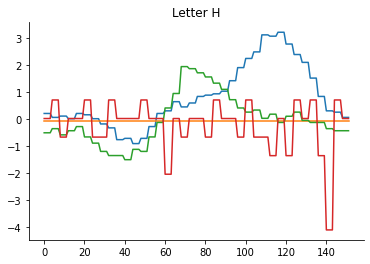

In [5]:
# Visualize single data point
i = 123
plt.plot(data[i])
plt.title("Letter %s"%letter_written[labels[i]])
sns.despine()

### Setup of the spiking network model

In [6]:
nb_channels = len(nzid)
enc_fan_out = 32  # Num of spiking neurons used to encode each channel

# Network parameters
nb_inputs  = nb_channels*enc_fan_out
nb_hidden  = 200
nb_outputs = len(np.unique(labels))+1
time_step = 2e-3/nb_upsample # TODO needs to be updated to reflect the correct time scale
nb_steps = nb_upsample*data_steps  # TODO We should change this and upsample the input data

batch_size = 100

print("Number of training data %i"%len(ds_train))
print("Number of testing data %i"%len(ds_test))
print("Number of outputs %i"%nb_outputs)
print("Number of timesteps %i"%nb_steps)

Number of training data 1080
Number of testing data 270
Number of outputs 28
Number of timesteps 152


In [7]:
tau_mem = 20e-3
tau_syn = 10e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [8]:
encoder_weight_scale = 1.0
fwd_weight_scale = 3.0
rec_weight_scale = 1e-2*fwd_weight_scale

# Parameters

# Encoder 
enc_gain = torch.empty((nb_inputs,),  device=device, dtype=dtype, requires_grad=True)
enc_bias = torch.empty((nb_inputs,),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(enc_gain, mean=0.0, std=encoder_weight_scale) # TODO update this parameter
torch.nn.init.normal_(enc_bias, mean=0.0, std=1.0)

# Spiking network
w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=fwd_weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=fwd_weight_scale/np.sqrt(nb_hidden))

v1 = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(v1, mean=0.0, std=rec_weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [9]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5, **kwargs):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i], **kwargs)
        ax.axis("off")

In [10]:
from IPython.display import clear_output

def live_plot(loss):
    if len(loss) == 1:
        return
    clear_output(wait=True)
    ax = plt.figure(figsize=(3,2), dpi=150).gca()
    ax.plot(range(1, len(loss) + 1), loss)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.xaxis.get_major_locator().set_params(integer=True)
    sns.despine()
    plt.show()

## Training the network

In [11]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 20.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [12]:
def run_snn(inputs):
    bs = inputs.shape[0]
    enc = torch.zeros((bs,nb_inputs), device=device, dtype=dtype)
    input_spk = torch.zeros((bs,nb_inputs), device=device, dtype=dtype)
    syn = torch.zeros((bs,nb_hidden), device=device, dtype=dtype)
    mem = -1e-3*torch.ones((bs,nb_hidden), device=device, dtype=dtype)
    out = torch.zeros((bs,nb_hidden), device=device, dtype=dtype)
    
    enc_rec = []
    mem_rec = []
    spk_rec = [] 
    
    # encoder_currents = torch.einsum("abc,c->ab", (inputs.tile((enc_fan_out,)), enc_gain))+enc_bias
    encoder_currents = enc_gain*(inputs.tile((enc_fan_out,))+enc_bias)
    for t in range(nb_steps):
        # Compute encoder activity
        new_enc = (beta*enc +(1.0-beta)*encoder_currents[:,t])*(1.0-input_spk.detach())
        input_spk = spike_fn(enc-1.0)
        
        # Compute hidden layer activity
        h1 = input_spk.mm(w1) + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1
        new_mem =(beta*mem +(1.0-beta)*syn)*(1.0-rst)

        # Here we store some state variables so we can look at them later.
        mem_rec.append(mem.detach())
        spk_rec.append(out.detach())
        enc_rec.append(enc.detach())
        
        enc = new_enc
        mem = new_mem
        syn = new_syn

    enc_rec = torch.stack(enc_rec,dim=1)  
    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((bs,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((bs,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +(1.0-beta)*flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [enc_rec, mem_rec, spk_rec]
    return out_rec, other_recs

In [13]:
def train(dataset, lr=1e-3, nb_epochs=10):
    
    params = [enc_gain, enc_bias, w1,w2,v1]
    optimizer = torch.optim.Adamax(params, lr=lr, betas=(0.9,0.995))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    generator = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in generator:
            x_local, y_local = x_local.to(device), y_local.to(device)
            output,recs = run_snn(x_local)
            _,_,spks=recs
            m,_=torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            
            # Here we can set up our regularizer loss
            reg_loss = 1e-3*torch.mean(torch.sum(spks,1)) # e.g., L1 loss on total number of spikes
            # reg_loss = 0.0
            
            # Here we combine supervised loss and the regularizer
            loss_val = loss_fn(log_p_y, y_local) + reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        
        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        live_plot(loss_hist)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        
    return loss_hist
        
        
def compute_classification_accuracy(dataset):
    """ Computes classification accuracy on supplied data in batches. """
    generator = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    accs = []
    for x_local, y_local in generator:
        x_local, y_local = x_local.to(device), y_local.to(device)
        output,_ = run_snn(x_local)
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [14]:
nb_epochs = 1000

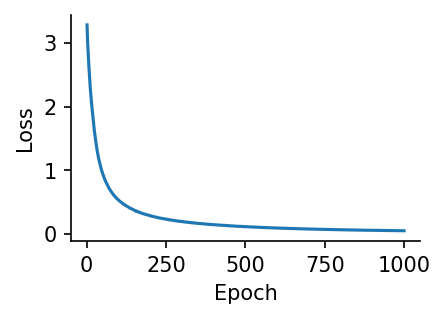

Epoch 1000: loss=0.04878


In [15]:
loss_hist = train(ds_train, lr=1e-2, nb_epochs=nb_epochs)

In [16]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(ds_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(ds_test)))

Training accuracy: 0.996
Test accuracy: 0.818


In [17]:
# Let's run the network on a single batch from the test set
data_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)
x_batch, y_batch = next(iter(data_loader))
output, other_recordings = run_snn(x_batch.to(device))
enc_rec, mem_rec, spk_rec = other_recordings

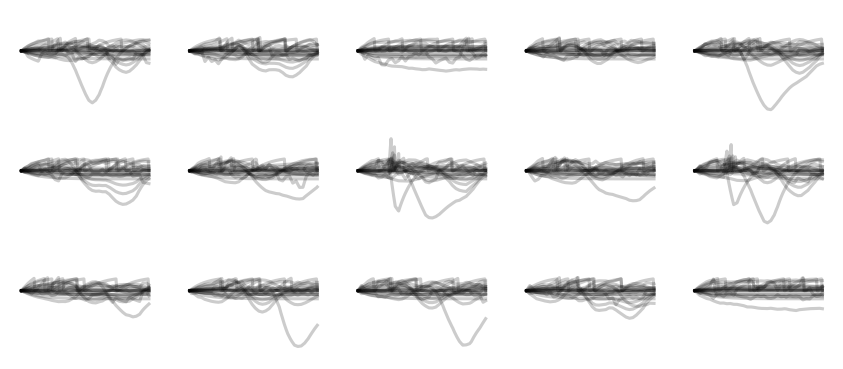

In [18]:
# This is how our spiking encoders convert the current based input into spike trains (we plot 20)

fig=plt.figure(dpi=150,figsize=(7,3))
plot_voltage_traces(enc_rec[:,:,:20], color="black", alpha=0.2)

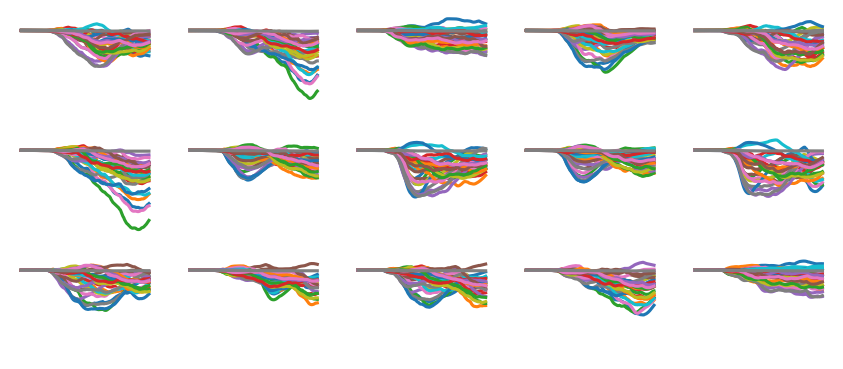

In [19]:
# Let's take a look at the readout layer activity 

fig=plt.figure(dpi=150,figsize=(7,3))
plot_voltage_traces(output)

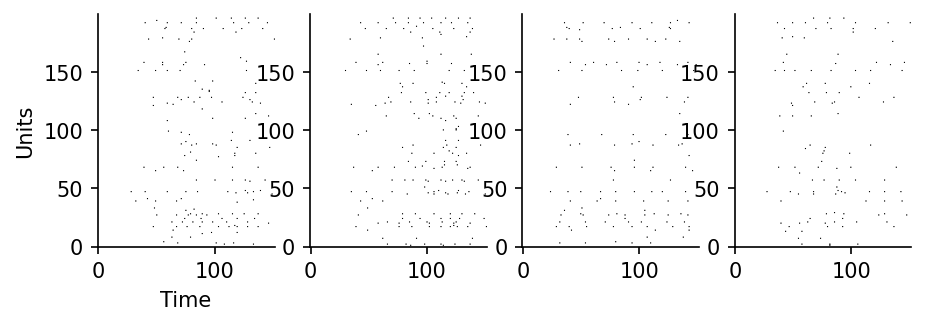

In [20]:
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.